In [12]:
import sys 
sys.path.insert(1, "../")
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import ast

import dask.dataframe as dd
from dask.dataframe import from_pandas

from workloads.util import use_results, use_dataset, join_queries_features
from workloads.stl.stl_util import predict, predict_seasonality

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from sklearn.linear_model import LogisticRegression

# Read Experiment Data 
* Currently, just read feature results / join against queries for one expeirment 
* Ideally combine together data from different experiments 

In [310]:
experiment = "stl-yahoo-A4-keys-100-interval-10000-events-200000-queries-200000"
results_dir = use_results(experiment)
dataset_dir = use_dataset(experiment)

/data/wooders/ralf-vldb//datasets/stl-yahoo-A4-keys-100-interval-10000-events-200000-queries-200000


In [223]:
result_df = pd.read_csv(f"{results_dir}/results_workers_1_lifo_window_672_slide_48.csv")
result_df["timestamp"] = result_df["processing_time"]

In [224]:
timestamp_df = pd.read_csv(f"{results_dir}/results_workers_1_lifo_window_672_slide_48_timestamps.csv")
queries_df = pd.read_csv(f"{dataset_dir}/queries.csv")
queries_df = queries_df.merge(timestamp_df, on="timestamp_ms")

In [225]:
joined_df = join_queries_features(queries_df, result_df)

100%|██████████| 194500/194500 [02:28<00:00, 1311.91it/s]


In [312]:
joined_df.to_csv(f"{results_dir}/query_results_workers_1_lifo_window_672_slide_672.csv")

In [313]:
joined_df = pd.read_csv(f"{results_dir}/query_results_workers_1_lifo_window_672_slide_672.csv")
joined_df["seasonality"] = joined_df['seasonality'].apply(ast.literal_eval)
joined_df["trend"] = joined_df['trend'].apply(ast.literal_eval)

In [314]:
df = queries_df.merge(joined_df, on=["query_id", "key_id"], suffixes=('_query', '_feature'))

In [315]:
df["prediction"] = df.dropna().apply(lambda x: predict(
        int(x["value"]), 
        int(x["trend"][-1]), 
        x["seasonality"], 
        int(x["timestamp_ms_query"]), 
        int(x["timestamp_ms_feature"]), 
        interval=5
), axis=1)

In [268]:
df

,Unnamed: 0,key_id,value,timestamp_ms_query,query_id,timestamp_query,trend,seasonality,timestamp_ms_feature,processing_time,runtime,ingest_time,timestamp_feature,query_key_id,query_timestamp,prediction
0,2704,2,-731.736800,3520,2704,1.645947e+09,"[327.5775368367989, 316.6151729890695, 305.645...","[-28.368407719026756, -9.086808902404467, 50.4...",3355,1.645947e+09,0.394175,1.645947e+09,1.645947e+09,2.0,1.645947e+09,323.747888
1,2705,2,-844.114178,3525,2705,1.645947e+09,"[327.5775368367989, 316.6151729890695, 305.645...","[-28.368407719026756, -9.086808902404467, 50.4...",3355,1.645947e+09,0.394175,1.645947e+09,1.645947e+09,2.0,1.645947e+09,208.581346
2,2706,2,-863.243142,3530,2706,1.645947e+09,"[327.5775368367989, 316.6151729890695, 305.645...","[-28.368407719026756, -9.086808902404467, 50.4...",3355,1.645947e+09,0.394175,1.645947e+09,1.645947e+09,2.0,1.645947e+09,168.414611
3,2707,2,-853.246620,3535,2707,1.645947e+09,"[327.5775368367989, 316.6151729890695, 305.645...","[-28.368407719026756, -9.086808902404467, 50.4...",3355,1.645947e+09,0.394175,1.645947e+09,1.645947e+09,2.0,1.645947e+09,134.368408
4,2708,2,-649.972517,3540,2708,1.645947e+09,"[327.5775368367989, 316.6151729890695, 305.645...","[-28.368407719026756, -9.086808902404467, 50.4...",3355,1.645947e+09,0.394175,1.645947e+09,1.645947e+09,2.0,1.645947e+09,319.086809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77200,177944,89,1963.828935,9720,177944,1.645947e+09,"[593.4257578930368, 571.2290824079173, 548.192...","[-59.732998513278105, 6.936026070887481, 181.7...",5515,1.645947e+09,0.103806,1.645947e+09,1.645947e+09,89.0,1.645947e+09,1343.063974
77201,115944,58,1047.246245,9720,115944,1.645947e+09,"[1006.3627256283537, 994.1465012156692, 981.00...","[-30.494220365592327, -8.580729513387226, 43.4...",4795,1.645947e+09,0.114807,1.645947e+09,1.645947e+09,58.0,1.645947e+09,-1028.419270
77202,165944,83,-3257.870528,9720,165944,1.645947e+09,"[-242.65315494366772, -262.49377421547337, -28...","[-137.05181700379808, -9.46992501546153, 205.2...",4795,1.645947e+09,0.111413,1.645947e+09,1.645947e+09,83.0,1.645947e+09,-1013.530075
77203,35944,18,4704.447669,9720,35944,1.645947e+09,"[1968.7828465288012, 1956.2726757761925, 1942....","[-17.709280176728022, 104.53708562503483, 444....",5995,1.645947e+09,0.101914,1.645947e+09,1.645947e+09,18.0,1.645947e+09,1797.462914


In [229]:
oracle_df = pd.read_csv(f"{dataset_dir}/oracle_features_672.csv").dropna()
oracle_df["seasonality"] = oracle_df['seasonality'].dropna().apply(ast.literal_eval)

In [230]:
oracle_query_df = queries_df.merge(oracle_df, on=["timestamp_ms", "key_id", "value"])

In [231]:
oracle_query_df["prediction"] = oracle_query_df.dropna().apply(lambda x: predict(
        int(x["value"]), 
        int(x["trend"]), 
        x["seasonality"], 
        int(x["timestamp_ms"]), 
        int(x["timestamp_ms"]), 
        interval=5
    ), axis=1)
oracle_query_df

,Unnamed: 0_x,key_id,value,timestamp_ms,query_id,timestamp,Unnamed: 0_y,trend,noise,outlier,seasonality,timestamp_ms.1,key_id.1,prediction
0,10671,6,-2031.731179,3355,10671,1.645947e+09,671,-1722.138682,-179.562225,0.0,"[-438.41445878371496, 20.915651101082947, 559....",3355,6,129.414459
1,174671,88,-1352.079809,3355,174671,1.645947e+09,671,-1117.348807,58.546443,0.0,"[-323.39704044739165, -155.26029226523005, 277...",3355,88,88.397040
2,192671,97,1859.207978,3355,192671,1.645947e+09,671,2045.857039,15.302189,0.0,"[-217.73544291946482, 85.50421590502249, 262.7...",3355,97,31.735443
3,86671,44,131.709271,3355,86671,1.645947e+09,671,1111.006064,-65.864757,0.0,"[-748.6440428397661, 177.99368904123864, 465.8...",3355,44,-231.355957
4,136671,69,-272.363200,3355,136671,1.645947e+09,671,5.953501,-11.702695,0.0,"[-267.0470758299926, -64.21271713979031, 378.8...",3355,69,-9.952924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127395,177944,89,1963.828935,9720,177944,1.645947e+09,1944,1946.924333,14.142855,106.0,"[-46.272997353256166, 186.2606430747878, 385.5...",9720,89,63.272997
127396,115944,58,1047.246245,9720,115944,1.645947e+09,1944,630.368400,73.651077,280.0,"[263.26713089618414, 477.7401300038177, 782.13...",9720,58,153.732869
127397,165944,83,-3257.870528,9720,165944,1.645947e+09,1944,-3083.767702,5.895883,52.0,"[-130.16435185013557, 20.561851793502225, 193....",9720,83,-43.835648
127398,35944,18,4704.447669,9720,35944,1.645947e+09,1944,4974.168346,-20.587693,-82.0,"[-277.05881035574487, 196.33440193342602, 562....",9720,18,7.058810


In [232]:
oracle_query_df = oracle_query_df.set_index("query_id")

# Generate Training Dataset 

In [280]:
# x = [(staleness, key)], # y = [(error)]

X = []
Y = [] 

for key in range(1, 101, 1):
    X.append((0, key))
    Y.append(0)
    
#for index, row in oracle_query_df.iterrows():
#    error = row["noise"] - row["prediction"]
#    X.append((0, row["key_id"]))
#    Y.append(error)
    
    
for index, row in df.iterrows():
    staleness = row["timestamp_ms_query"] - row["timestamp_ms_feature"]
    
    # error can be either compared with oracle prediction or ground truth 
    error = oracle_query_df.loc[row["query_id"]]["prediction"] - row["prediction"]
    X.append((staleness, row["key_id"]))
    Y.append(error)
    #print(X[-1], error)
    
    
    
    

## Create Linear Model Per-Key 
TODO: Make this just one model 

In [306]:
import math

models = {}
for key in range(1, 101, 1): 
    s = []
    e = []
    for i in range(len(X)):
        if X[i][1] == key: 
            #if Y[i]*Y[i] > 10000: continue
            if X[i][0] > 5000: continue  
            s.append(X[i][0])
            e.append(math.sqrt(Y[i]*Y[i]))
            #print(X[i], Y[i])

    clf = LinearRegression().fit([[x] for x in s], e)
    models[key] = {"x": s, "y": e, "model": clf}
        

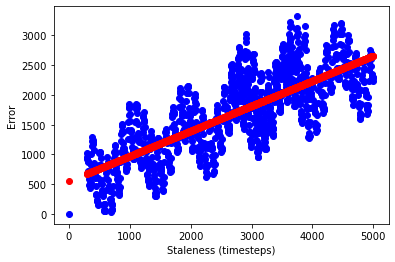

In [309]:
import matplotlib.pyplot as plt

# plot single key 

key = 3
plt.scatter(models[key]["x"], models[key]["y"], c ="blue")
plt.scatter(models[key]["x"], [models[key]["model"].predict([[x] for x in models[key]["x"]])], c ="red")
plt.ylabel("Error")
plt.xlabel("Staleness (timesteps)")
plt.show()

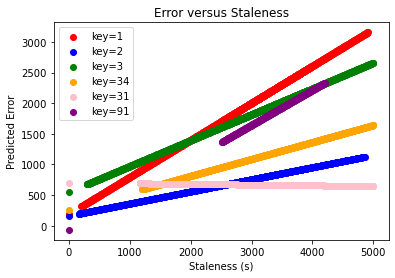

In [303]:
import matplotlib.pyplot as plt

# compare multiple keys 

key = 1 
plt.scatter(models[key]["x"], [models[key]["model"].predict([[x] for x in models[key]["x"]])], c ="red", label=f"key={key}")
 
key = 2 
plt.scatter(models[key]["x"], [models[key]["model"].predict([[x] for x in models[key]["x"]])], c ="blue", label=f"key={key}")
 
key = 3
plt.scatter(models[key]["x"], [models[key]["model"].predict([[x] for x in models[key]["x"]])], c ="green", label=f"key={key}")
 
key = 34
plt.scatter(models[key]["x"], [models[key]["model"].predict([[x] for x in models[key]["x"]])], c ="orange", label=f"key={key}")
 
 
key = 31
plt.scatter(models[key]["x"], [models[key]["model"].predict([[x] for x in models[key]["x"]])], c ="pink", label=f"key={key}")
 
key = 91
plt.scatter(models[key]["x"], [models[key]["model"].predict([[x] for x in models[key]["x"]])], c ="purple", label=f"key={key}")
 
plt.legend()
# To show the plot
plt.title("Error versus Staleness")
plt.ylabel("Predicted Error")
plt.xlabel("Staleness (s)")
plt.show()